In [1]:
import pandas as pd 
import os 
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, ifft
import numpy as np

In [2]:
df = pd.read_hdf('20241128_no_source_8.5bar_Ar_roomtemp_no_amp_4.h5')
df.head()

,TIME,CH1,CH2,CH3,CH4,event,event_time
0,-0.000002,0.000195,0.000601,0.000016,-0.000059,0,1.732790e+09
1,-0.000002,0.000239,0.000573,0.000035,-0.000082,0,1.732790e+09
2,-0.000002,0.000291,0.000579,0.000036,-0.000078,0,1.732790e+09
3,-0.000002,0.000358,0.000563,0.000032,-0.000102,0,1.732790e+09
4,-0.000002,0.000397,0.000547,0.000033,-0.000071,0,1.732790e+09


/var/folders/pd/hx80lcqj1szc4vdz3mbmmv680000gn/T/ipykernel_3685/2489715186.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_event[ch].replace([np.inf, -np.inf], max_finite_value, inplace=True)  # Replace inf values
/var/folders/pd/hx80lcqj1szc4vdz3mbmmv680000gn/T/ipykernel_3685/2489715186.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

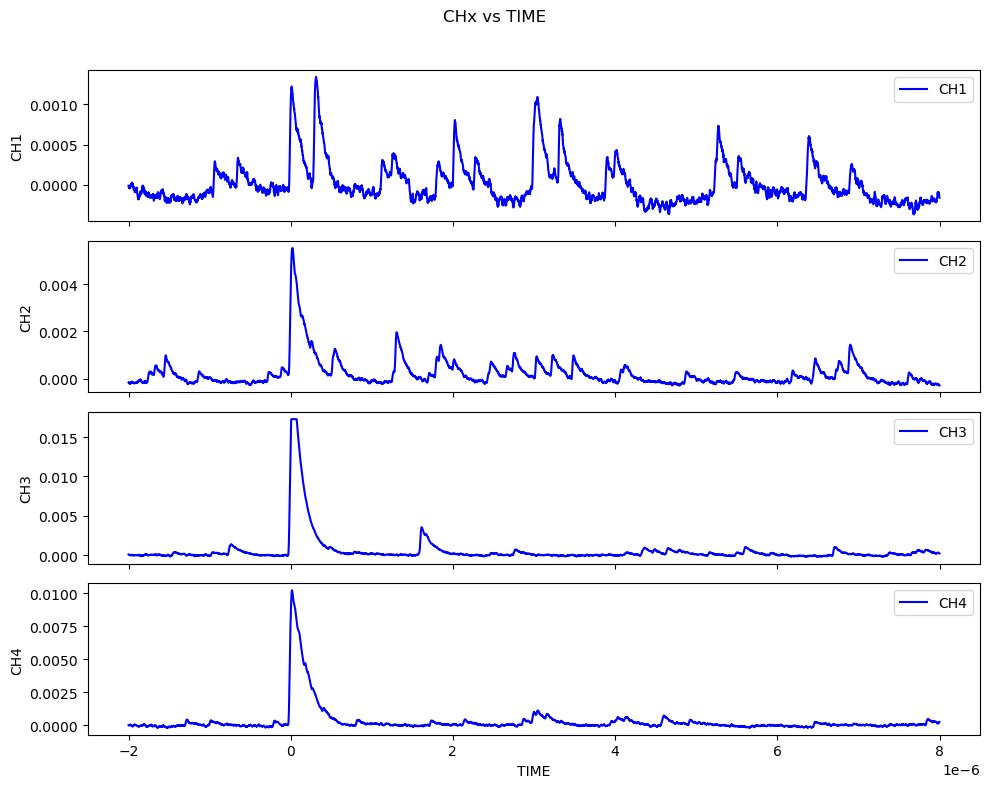

In [3]:
event = 420
df_event = df[df['event']==event]

for ch in ['CH1', 'CH2', 'CH3', 'CH4']:
    max_finite_value = df_event[ch][np.isfinite(df_event[ch])].max()  # Find the max finite value
    df_event[ch].replace([np.inf, -np.inf], max_finite_value, inplace=True)  # Replace inf values
    
# Set up the subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
fig.suptitle('CHx vs TIME')

# Plot each channel in its own subplot
channels = ['CH1', 'CH2', 'CH3', 'CH4']
for i, ch in enumerate(channels):
    axs[i].plot(df_event['TIME'], df_event[ch], label=ch, color='b')
    axs[i].set_ylabel(ch)
    axs[i].legend(loc='upper right')

# Set the x-axis label for the last subplot
axs[-1].set_xlabel('TIME')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
plt.show()

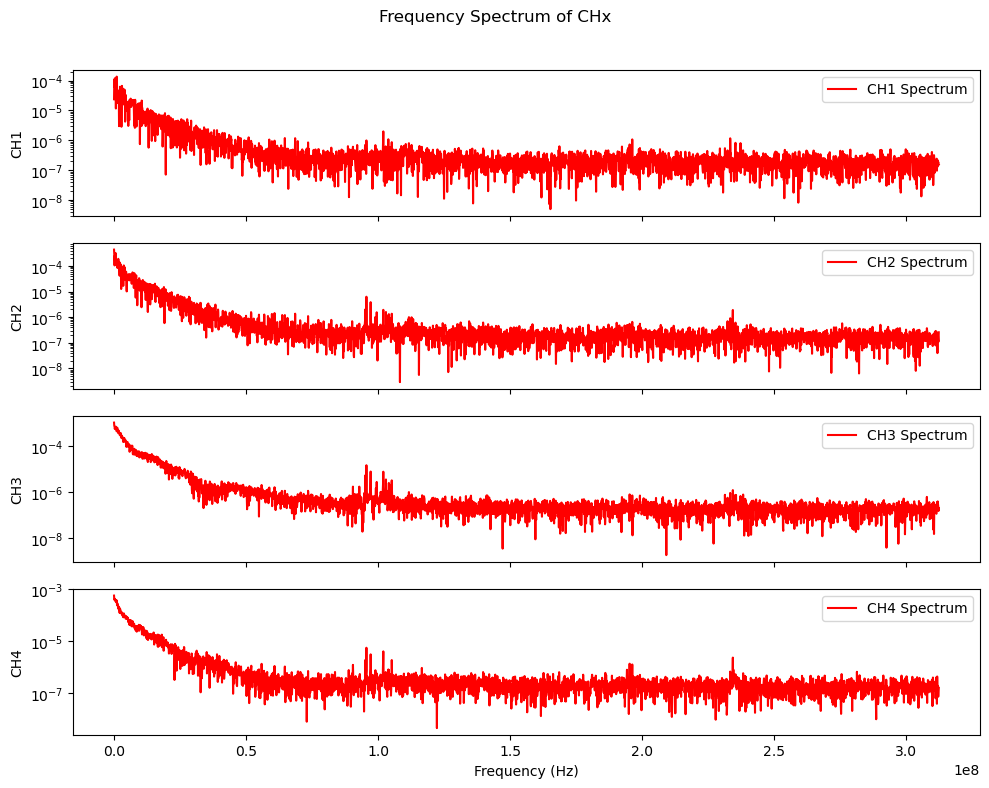

In [4]:
time = df_event['TIME'].values
sampling_interval = time[1] - time[0]
sampling_rate = 1 / sampling_interval

# Set up the subplots for frequency spectrum
fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
fig.suptitle('Frequency Spectrum of CHx')

# Perform FFT and plot the frequency spectrum for each channel
channels = ['CH1', 'CH2', 'CH3', 'CH4']
for i, ch in enumerate(channels):
    # Perform Fourier Transform
    signal = df_event[ch].values
    N = len(signal)
    yf = fft(signal)
    xf = fftfreq(N, sampling_interval)[:N//2]  # Frequencies (one side of the spectrum)

    # Plot the amplitude spectrum
    axs[i].plot(xf, 2.0/N * np.abs(yf[:N//2]), label=f'{ch} Spectrum', color='r')
    axs[i].set_ylabel(ch)
    axs[i].set_yscale('log')
    axs[i].legend(loc='upper right')

# Set the x-axis label for the last subplot
axs[-1].set_xlabel('Frequency (Hz)')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
plt.show()

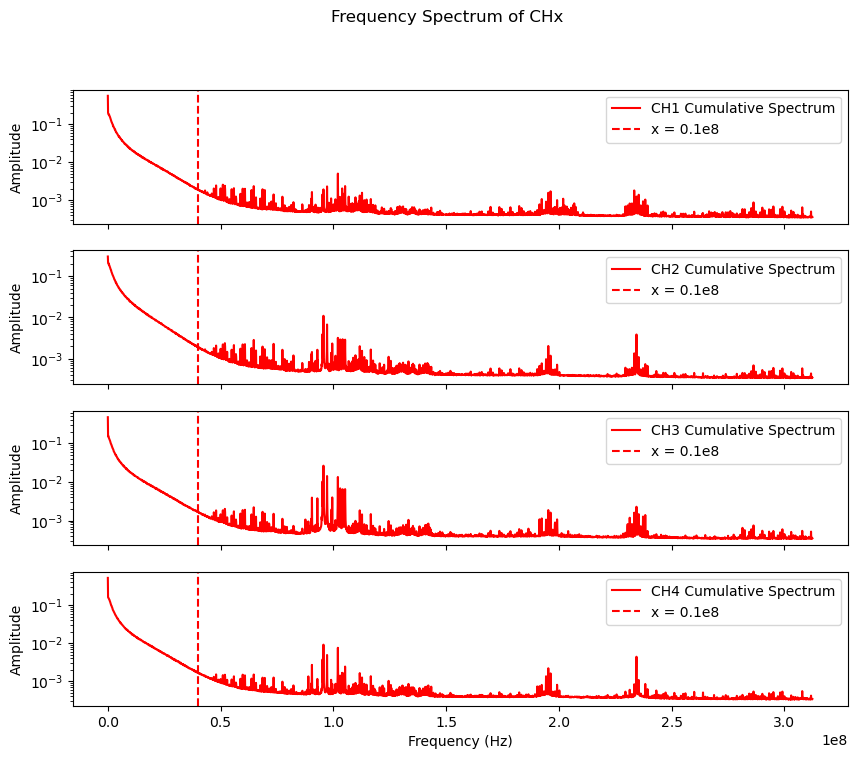

In [5]:
# Find unique events
unique_events = df['event'].unique()

# Dictionary to store the cumulative frequency spectra for each channel
cumulative_frequency_spectrum = {ch: None for ch in ['CH1', 'CH2', 'CH3', 'CH4']}
sampling_interval = df['TIME'].iloc[1] - df['TIME'].iloc[0]  # Assuming consistent sampling
N = len(df[df['event'] == unique_events[0]])  # Length of each event's data
xf = fftfreq(N, sampling_interval)[:N//2]  # Frequency bins (one side of the spectrum)

# Loop over each event and accumulate the frequency spectra
for event in unique_events:
    df_event = df[df['event'] == event]
    
    # Perform FFT for each channel and accumulate the amplitude spectra
    for ch in cumulative_frequency_spectrum.keys():
        signal = df_event[ch].values
        
        if len(signal) > 1:  # Ensure there's enough data for FFT
            yf = fft(signal)
            intensities = 2.0/N * np.abs(yf[:N//2])  # Amplitude spectrum
            
            # Accumulate the spectra
            if cumulative_frequency_spectrum[ch] is None:
                cumulative_frequency_spectrum[ch] = intensities
            else:
                if(intensities[0]!=np.inf):
                    cumulative_frequency_spectrum[ch] += intensities

            #print(event,ch,cumulative_frequency_spectrum[ch])

# Plot the cumulative frequency spectra for each channel
fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
fig.suptitle('Frequency Spectrum of CHx')

channels = ['CH1', 'CH2', 'CH3', 'CH4']
for i, ch in enumerate(channels):
    axs[i].plot(xf, cumulative_frequency_spectrum[ch], label=f'{ch} Cumulative Spectrum', color='r')
    axs[i].axvline(x=0.4e8, color='r', linestyle='--', label='x = 0.1e8')
    axs[i].set_ylabel('Amplitude')
    axs[i].set_yscale('log')  # Optional: log scale for intensity
    axs[i].legend(loc='upper right')

# Set the x-axis label for the last subplot
axs[-1].set_xlabel('Frequency (Hz)')

#plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
plt.show()

<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>


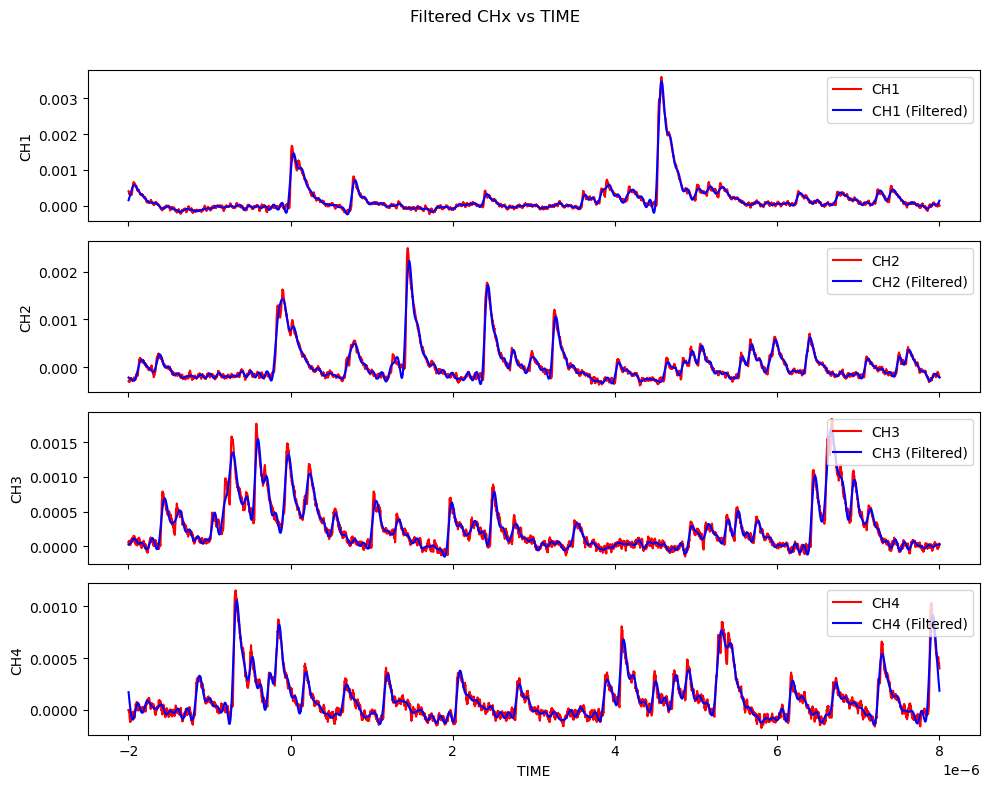

In [6]:
# Filter the data for the specified event
event = 190
df_event = df[df['event'] == event]

# Set up the cutoff frequency
cutoff_frequency = 0.1e8  # 5 MHz

# Prepare subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
fig.suptitle('Filtered CHx vs TIME')

# Define the sampling parameters
time = df_event['TIME'].values
sampling_interval = time[1] - time[0]
sampling_rate = 1 / sampling_interval
N = len(time)

# Plot each filtered channel in its own subplot
channels = ['CH1', 'CH2', 'CH3', 'CH4']
for i, ch in enumerate(channels):
    # Get the original signal
    signal = df_event[ch].values
    
    # Perform Fourier Transform
    yf = fft(signal)
    xf = fftfreq(N, sampling_interval)

    # Apply the low-pass filter (zero out frequencies above cutoff)
    yf[np.abs(xf) > cutoff_frequency] = 0

    # Inverse FFT to obtain the filtered signal in time domain
    filtered_signal = ifft(yf).real

    # Plot the filtered signal
    axs[i].plot(df_event['TIME'], df_event[ch], label=ch, color='r')
    axs[i].plot(df_event['TIME'], filtered_signal, label=f'{ch} (Filtered)', color='b')
    axs[i].set_ylabel(ch)
    axs[i].legend(loc='upper right')
    print(type(df_event[ch]),type(filtered_signal))

# Set the x-axis label for the last subplot
axs[-1].set_xlabel('TIME')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
plt.show()